In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from transformers import TFAutoModel, AutoTokenizer
from datasets import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import collections

d:\文大專題\program\Lingspam\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# 1. 讀取資料（已更新為新的 CSV 檔案）
file_path = "test(2).csv"
df = pd.read_csv(file_path)

In [3]:
# 檢查 label 欄位內容
print("label 欄位內容（前 10 筆）：")
print(df['label'].head(10))
print("label 欄位型態：", df['label'].dtype)
print("有多少 NaN：", df['label'].isna().sum())

label 欄位內容（前 10 筆）：
0    5.0
1    3.0
2    3.0
3    2.0
4    5.0
5    2.0
6    3.0
7    5.0
8    2.0
9    5.0
Name: label, dtype: float64
label 欄位型態： float64
有多少 NaN： 1


In [4]:
# 正確處理：移除 NaN，直接轉 int
df = df.dropna(subset=['label'])                # 移除 NaN
df['label'] = df['label'].astype(int)           # 直接轉 int

In [5]:
# 再次確認 label 是否正常（應該都是 0~6）
print("資料集內 label 類型:", sorted(df['label'].unique()))

資料集內 label 類型: [1, 2, 3, 4, 5, 6]


In [6]:
# 2. 合併主旨與內容作為輸入文字（不清理超連結與 email）
texts = [(subject if pd.notnull(subject) else '') + ' ' + (message if pd.notnull(message) else '')
         for subject, message in zip(df['subject'], df['message'])]
labels = df['label'].tolist()

In [7]:
# 顯示各類別數量
label_counts = collections.Counter(labels)
print("整個資料集 各類別數量:")
for label, count in sorted(label_counts.items()):
    print(f"類別 {label}: {count} 筆")

整個資料集 各類別數量:
類別 1: 54 筆
類別 2: 421 筆
類別 3: 586 筆
類別 4: 452 筆
類別 5: 304 筆
類別 6: 181 筆


In [8]:
# 3. 設定中文 BERT 模型與 tokenizer
MODEL_NAME = "hfl/chinese-roberta-wwm-ext"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

d:\文大專題\program\Lingspam\.venv\lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [9]:
# 4. 切分訓練/驗證集
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42)

In [10]:
# 顯示訓練集與驗證集各類別數量
train_label_counts = collections.Counter(train_labels)
print("\n訓練集 各類別數量:")
for label, count in sorted(train_label_counts.items()):
    print(f"類別 {label}: {count} 筆")

val_label_counts = collections.Counter(val_labels)
print("\n驗證集 各類別數量:")
for label, count in sorted(val_label_counts.items()):
    print(f"類別 {label}: {count} 筆")


訓練集 各類別數量:
類別 1: 40 筆
類別 2: 341 筆
類別 3: 472 筆
類別 4: 364 筆
類別 5: 229 筆
類別 6: 152 筆

驗證集 各類別數量:
類別 1: 14 筆
類別 2: 80 筆
類別 3: 114 筆
類別 4: 88 筆
類別 5: 75 筆
類別 6: 29 筆


In [11]:
# 5. 編碼資料
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

train_ds = Dataset.from_dict({"text": train_texts, "label": train_labels}).map(tokenize_function, batched=True)
val_ds = Dataset.from_dict({"text": val_texts, "label": val_labels}).map(tokenize_function, batched=True)

Map: 100%|██████████| 400/400 [00:00<00:00, 2920.78 examples/s]


In [12]:
# 6. 轉為 TensorFlow 格式
train_tfds = train_ds.to_tf_dataset(
    columns=["input_ids", "attention_mask"],
    label_cols="label",
    shuffle=True,
    batch_size=16,
)
val_tfds = val_ds.to_tf_dataset(
    columns=["input_ids", "attention_mask"],
    label_cols="label",
    shuffle=False,
    batch_size=16,
)

In [13]:
# 7. 構建模型
encoder = TFAutoModel.from_pretrained(MODEL_NAME)
input_ids = tf.keras.Input(shape=(128,), dtype=tf.int32, name="input_ids")
attention_mask = tf.keras.Input(shape=(128,), dtype=tf.int32, name="attention_mask")

embedding = encoder(input_ids, attention_mask=attention_mask)[1]  # pooled output
output = tf.keras.layers.Dense(7, activation="softmax")(embedding)
model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at hfl/chinese-roberta-wwm-ext.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [14]:
# 8. 編譯模型（降低 learning rate，防止 loss 爆炸）
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"])


In [15]:
# 9. 訓練模型
model.fit(train_tfds, validation_data=val_tfds, epochs=3)

Epoch 1/3
100/100 [==============================] - 28s 212ms/step - loss: 0.5197 - accuracy: 0.8442 - val_loss: 0.1474 - val_accuracy: 0.9450
Epoch 2/3
100/100 [==============================] - 20s 203ms/step - loss: 0.0953 - accuracy: 0.9787 - val_loss: 0.0869 - val_accuracy: 0.9775
Epoch 3/3
100/100 [==============================] - 20s 200ms/step - loss: 0.0420 - accuracy: 0.9937 - val_loss: 0.0750 - val_accuracy: 0.9825


25/25 [==============================] - 3s 63ms/step

Classification Report:

              precision    recall  f1-score   support

           1     1.0000    1.0000    1.0000        14
           2     0.9639    1.0000    0.9816        80
           3     1.0000    1.0000    1.0000       114
           4     0.9778    1.0000    0.9888        88
           5     0.9867    0.9867    0.9867        75
           6     0.9583    0.7931    0.8679        29

    accuracy                         0.9825       400
   macro avg     0.9811    0.9633    0.9708       400
weighted avg     0.9824    0.9825    0.9818       400



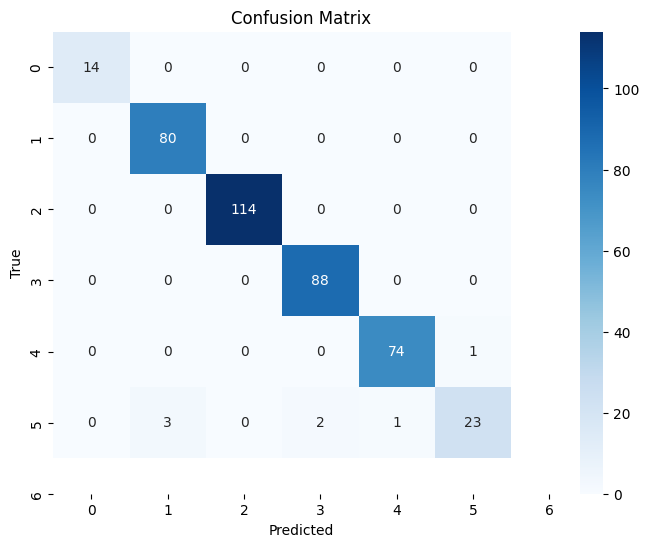

In [16]:
# 10. 驗證分析（classification report 與混淆矩陣）
pred_probs = model.predict(val_tfds)
pred_labels = np.argmax(pred_probs, axis=1)
true_labels = np.array(val_labels)

print("\nClassification Report:\n")
print(classification_report(true_labels, pred_labels, digits=4))

cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(7), yticklabels=range(7))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()